# Classificação de Faces

A rede neural artificial aqui utilizada é uma variante da arquitetura inception. Uma variante NN4 do projeto OpenFace. A implementação usa uma implementação Keras do modelo pego do projeto Keras-OpenFace. 

In [2]:
from model import create_model

nn4_small2 = create_model()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


O treinamento do modelo visa aprender um embedding $f(x)$  de uma imagem $x$, cuja distância quadrada L2 entre todas as faces da mesma identidade é pequena e a distância entre os pares de faces de diferentes identidades é grande. Isso pode ser atingido através do _triplet loss_ L que é minimizado quando a distância entre uma imagem âncora $x_i^a$ e uma imagem positiva $x_i^p$(de mesma identidade) no espaço é menor que a distância entre aquela imagem âncora e uma imagem negativa $x_i^n$ em pelo menos uma margem $\alpha$.

$\begin{aligned}
L = \sum_{i = 1}^{m}{[\lVert f(x_i^a) - f(x_i^p) \rVert_2^2 - \lVert f(x_i^a) - f(x_i^n) \rVert_2^2 + \alpha]}_+
\end{aligned}$

$[Z]_+$ significa $max(z, 0)$ e $m$ é o número de triplas no conjunto de treinamento. O _triplet loss_ no Keras é melhor implementado com uma camada personalizada, pois a função de perda não segue o padrão de perda(entrada, destino) usual:

In [3]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Entrada para imagens âncora, postiva e negativa
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Sáida para vetores embutidos âncora, positivo e negativo
# o modelo de instâncias nn4_small é compartilhado (Redes Siamesas)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Camada que computa o triplet loss para os vetores embutidos âncora, positivo e negativo
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Modelo que pode ser treinado com imagens âncora, positiva e negativa
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)


Durante o treinamento, é importante selecionar as triplas cujos pares positivos $(x_a^i, x_p^i)$ e pares negativos $(x_a^i, x_n^i)$ sejam difíceis de discriminar, ou seja, a diferença de distância no espaço de incorporação deve ser menor que a margem $\alpha$, senão a rede não estará habilitada a aprender embeddings úteis. Portanto, cada iteração de treinamento deve selecionar um novo lote de triplas com base nos embeddings aprendidos na iteração anterior. Supondo que um gerador retornado de uma chamada `triplet_generator()` possa gerar triplas sob essas restrições, a rede pode ser treinada com:

In [5]:
from data import triplet_generator

# triplet_generator() creates a generator that continuously returns
# ([a_batch, p_batch, n_batch], None) tuples where a_batch, p_batch
# and n_batch are batches of anchor, positive and negative RGB images
# each having a shape of (batch_size, 96, 96, 3).
generator = triplet_generator() 

nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100)

# Please note that the current implementation of the generator only generates
# random image data. The main goal of this code snippet is to demonstrate
# the general setup for model training. In the following, we will anyway
# use a pre-trained model so we don't need a generator here that operates
# on real training data. I'll maybe provide a fully functional generator
# later.

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
100/100 [==============================] - 92s 917ms/step - loss: 0.8082
Epoch 2/10
100/100 [==============================] - 80s 804ms/step - loss: 0.8011
Epoch 3/10
100/100 [==============================] - 76s 758ms/step - loss: 0.8004
Epoch 4/10
100/100 [==============================] - 78s 775ms/step - loss: 0.8010
Epoch 5/10
100/100 [==============================] - 77s 771ms/step - loss: 0.8005
Epoch 6/10
100/100 [==============================] - 80s 797ms/step - loss: 0.8004
Epoch 7/10
100/100 [==============================] - 78s 776ms/step - loss: 0.8001
Epoch 8/10
100/100 [==============================] - 74s 744ms/step - loss: 0.8002
Epoch 9/10
100/100 [==============================] - 74s 745ms/step - loss: 0.7997
Epoch 10/10
100/100 [==============================] - 76s 756ms/step - loss: 0.8004


O trecho de código acima deve apenas demonstrar como configurar o treinamento do modelo. Mas, em vez de realmente treinar um modelo a partir do zero, usaremos agora um modelo pré-treinado, já que o treinamento do zero é muito caro e requer conjuntos de dados enormes para alcançar um bom desempenho de generalização. Por exemplo, [1] usa um conjunto de dados de imagens de 200M consistindo em cerca de 8M de identidade.

O projeto OpenFace fornece modelos pré-treinados que foram treinados com os conjuntos de dados públicos de reconhecimento de rosto _FaceScrub_ e _CASIA-WebFace_. O projeto _Keras-OpenFace_ converteu os pesos do modelo `nn4.small2.v1` pré-treinado em arquivos CSV que foram então convertidos aqui em um formato binário que pode ser carregado por Keras com `load_weights()`:

In [6]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

## Dataset Customizado

Para demonstrar o reconhecimento facial em um conjunto de dados personalizado, um pequeno subconjunto do conjunto de dados LFW é usado. Consiste em 100 imagens faciais de 10 identidades. Os metadados para cada imagem (arquivo e nome de identidade) são carregados na memória para processamento posterior.

In [7]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')

## Alinhamento de Faces

Vamos implementar a detecção de face, transformação e recorte como função `align_image()` para posterior reutilização.

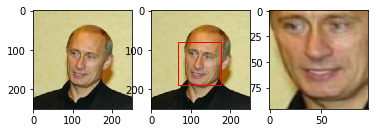

In [9]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

# Load an image of Jacques Chirac
jc_orig = load_image(metadata[2].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);


In [10]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

## Vetores embedding

Os vetores incorporados agora podem ser calculados alimentando as imagens alinhadas e dimensionadas na rede pré-treinada.

In [11]:
embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

Vamos verificar em um exemplo de tripla única que a distância L2 ao quadrado entre seu par âncora-positivo é menor que a distância entre seu par âncora-negativo.

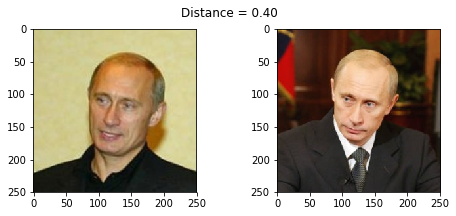

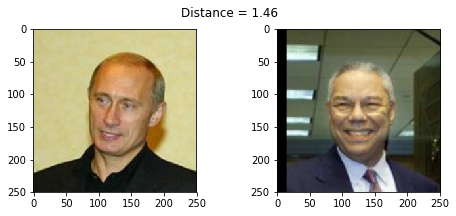

In [13]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 12)

Mas ainda não sabemos qual limite de distância $τ$ é o melhor limite para tomar uma decisão entre a mesma identidade e identidade diferente.

## Distância limítrofe

Para encontrar o valor ideal para $τ$, o desempenho da verificação da face deve ser avaliado em uma faixa de valores limítrofes de distância. Em um determinado limite, todos os possíveis pares de vetores embedding são classificados como _identidade igual_ ou _identidade diferente_ e comparados com o verdadeiro básico. Como estamos lidando com classes distorcidas (muito mais pares negativos do que pares positivos), usamos a pontuação F1 como métrica de avaliação em vez de precisão.

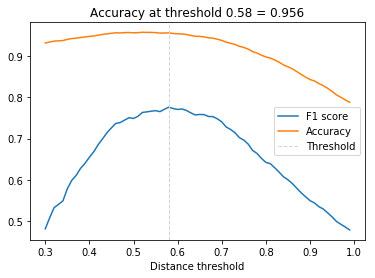

In [14]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

A acurácia de verificação da face em $τ$ = 0,56 é de 95,7%. Isso não é ruim considerando uma baseline de 89% para um classificador que sempre prevê identidade diferente (existem 980 pares pos e 8821 pares negados), mas como `nn4.small2.v1` é um modelo relativamente pequeno, ele ainda é menor do que o que pode ser alcançado por modelos de última geração (> 99%).

Os dois histogramas seguintes mostram as distribuições de distância de pares positivos e negativos e a localização do limite de decisão. Há uma separação clara dessas distribuições, o que explica o desempenho discriminativo da rede. Pode-se também detectar alguns pontos discrepantes fortes na classe de pares positivos, mas estes não são mais analisados aqui.

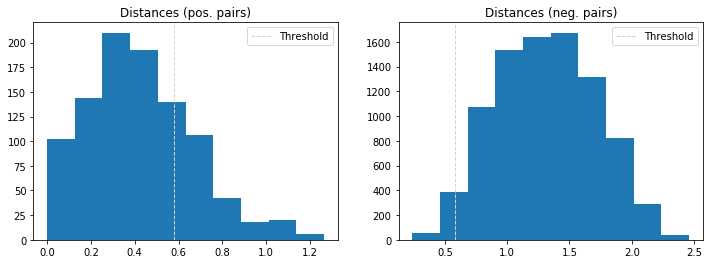

In [15]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

## Reconhecimento Facial

Dada uma estimativa do limiar de distância $τ$, o reconhecimento facial é agora tão simples quanto calcular as distâncias entre um vetor embedding de entrada e todos os vetores embedding em um banco de dados. A entrada recebe o rótulo (ou seja, identidade) da entrada do banco de dados com a menor distância, se for menor que $τ$ ou rótulo desconhecido, caso contrário. Esse procedimento também pode ser dimensionado para grandes bancos de dados, pois pode ser facilmente paralelizado. Ele também suporta o aprendizado de uma única vez, já que adicionar apenas uma única entrada de uma nova identidade pode ser suficiente para reconhecer novos exemplos dessa identidade.

Uma abordagem mais robusta é rotular a entrada usando as k entradas melhor avaliadas do banco de dados, que é essencialmente a classificação KNN com uma métrica de distância euclidiana. Alternativamente, uma máquina de vetores de suporte linear (SVM) pode ser treinada com as entradas do banco de dados e usada para classificar, ou seja, identificar novas entradas. Para treinar esses classificadores, usamos 50% do conjunto de dados, para avaliar os outros 50%.

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.94, SVM accuracy = 1.0


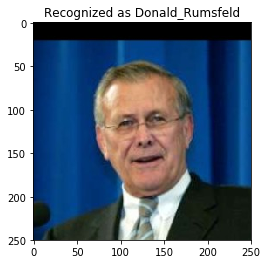

In [18]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 29

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embedded[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');

Parece razoável :-) Os resultados da classificação devem, na verdade, ser verificados se (um subconjunto das) as entradas do banco de dados da identidade prevista têm uma distância menor que $τ$, caso contrário, deve-se atribuir um rótulo desconhecido. Esta etapa é ignorada aqui, mas pode ser facilmente adicionada.

## Visualização do Dataset

Para incorporar o conjunto de dados ao espaço 2D para exibir clusters de identidade, a _incorporação de vizinho estocástica t-distribuída (t-SNE)_ é aplicada aos vetores de incorporação de 128 dimensões. Exceto por alguns outliers, os clusters de identidade estão bem separados.

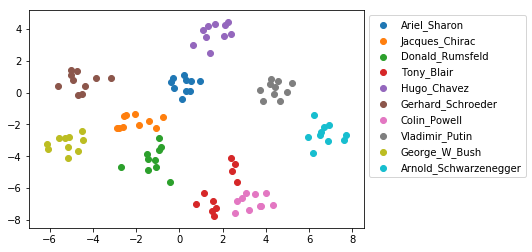

In [19]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1))

fonte: <http://krasserm.github.io/2018/02/07/deep-face-recognition/>